# Visualizações e Análise Exploratória

Este notebook gera visualizações dos dados e resultados do modelo.


In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 6)

# Configurações
POSTGRES_HOST = 'postgres'
POSTGRES_USER = 'postgres'
POSTGRES_PASSWORD = 'postgres'
POSTGRES_DB = 'inmet_db'

engine = create_engine(f'postgresql://{POSTGRES_USER}:{POSTGRES_PASSWORD}@{POSTGRES_HOST}:5432/{POSTGRES_DB}')


In [2]:
# Carrega dados tratados
df = pd.read_sql("SELECT * FROM dados_tratados ORDER BY datetime", engine)
df['datetime'] = pd.to_datetime(df['datetime'])
print(f"Total de registros: {len(df)}")


Total de registros: 7551


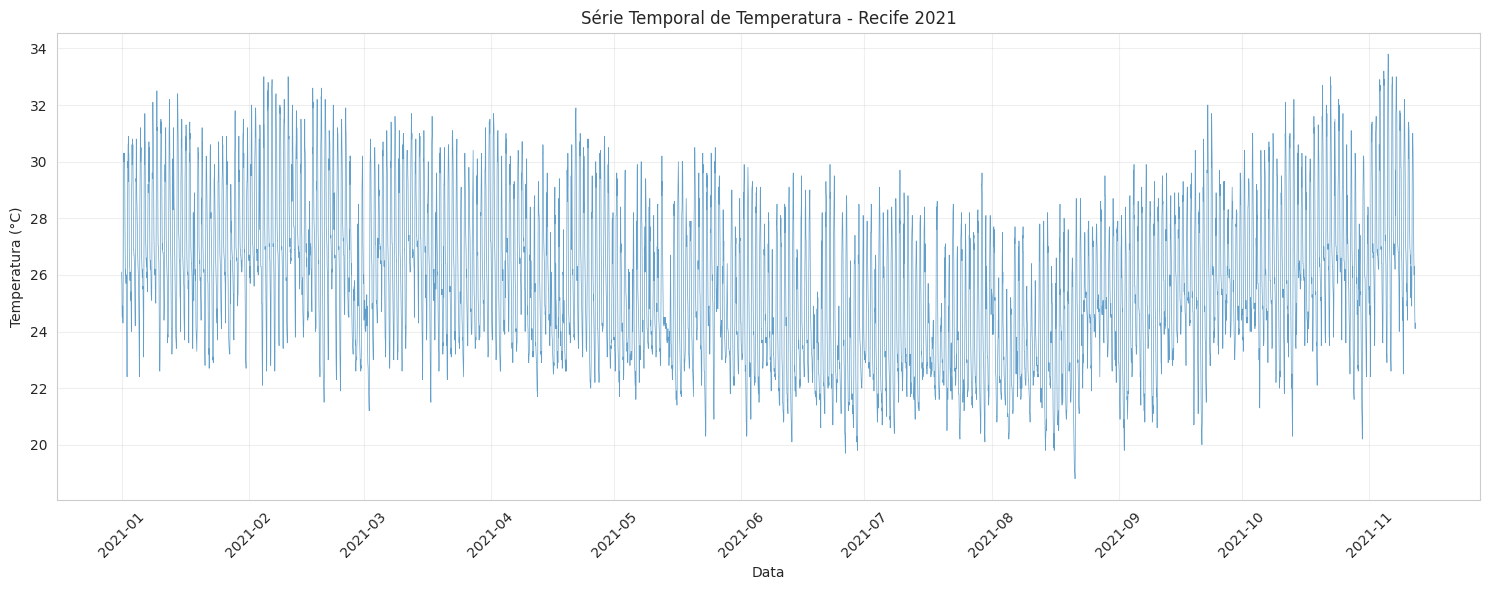

In [3]:
# Série temporal de temperatura
plt.figure(figsize=(15, 6))
plt.plot(df['datetime'], df['temperatura'], linewidth=0.5, alpha=0.7)
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.title('Série Temporal de Temperatura - Recife 2021')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/home/jovyan/work/serie_temporal_temperatura.png', dpi=300, bbox_inches='tight')
plt.show()


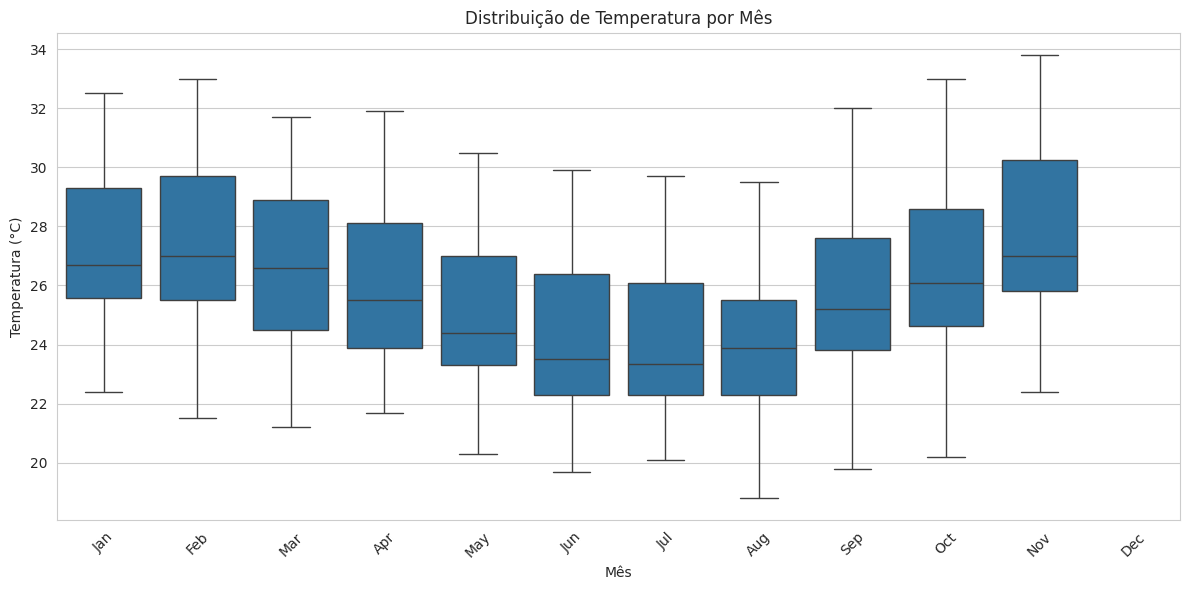

In [4]:
# Boxplot de temperatura por mês
df['mes_nome'] = df['datetime'].dt.strftime('%b')
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='mes_nome', y='temperatura', order=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                                           'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xlabel('Mês')
plt.ylabel('Temperatura (°C)')
plt.title('Distribuição de Temperatura por Mês')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/home/jovyan/work/temperatura_por_mes.png', dpi=300, bbox_inches='tight')
plt.show()


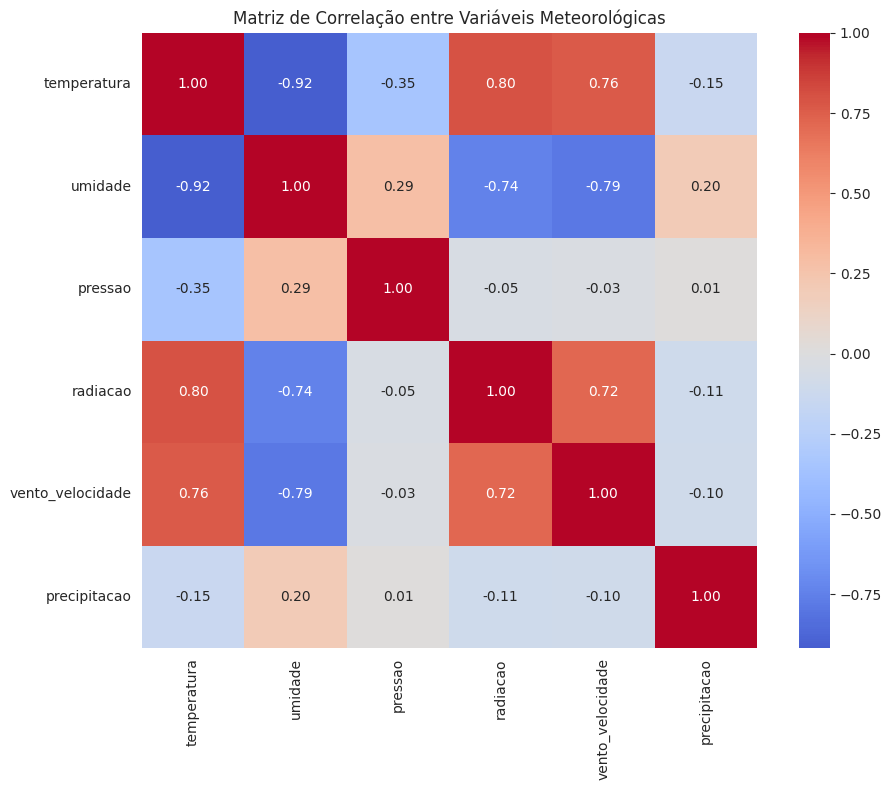

In [5]:
# Correlação entre variáveis
corr_cols = ['temperatura', 'umidade', 'pressao', 'radiacao', 'vento_velocidade', 'precipitacao']
corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, square=True)
plt.title('Matriz de Correlação entre Variáveis Meteorológicas')
plt.tight_layout()
plt.savefig('/home/jovyan/work/matriz_correlacao.png', dpi=300, bbox_inches='tight')
plt.show()


IndexError: single positional indexer is out-of-bounds

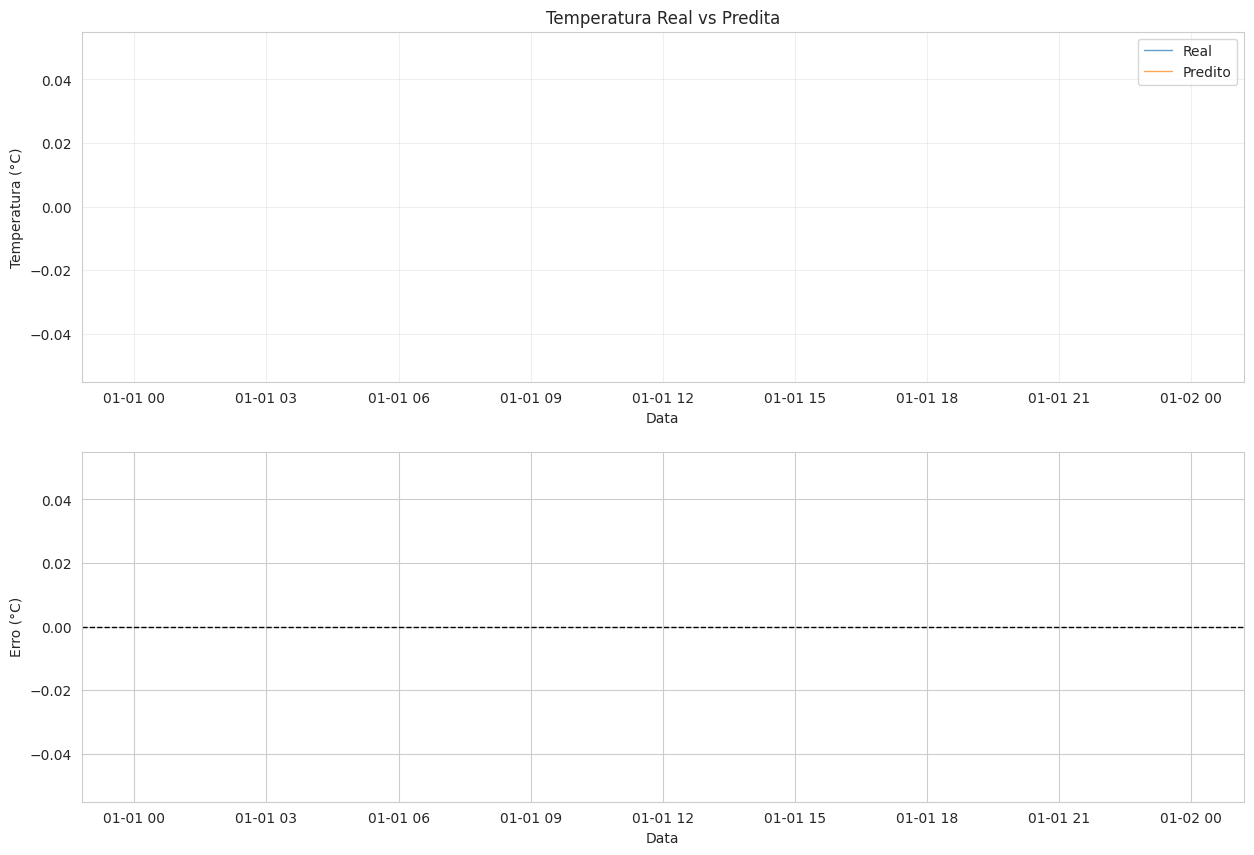

In [ ]:
# Visualização de predições
try:
    pred_df = pd.read_sql("SELECT * FROM predicoes_temperatura ORDER BY datetime", engine)
    
    if pred_df.empty:
        print("⚠️ Tabela predicoes_temperatura está vazia. Execute primeiro o notebook 02_modelagem_temperatura.ipynb")
    else:
        pred_df['datetime'] = pd.to_datetime(pred_df['datetime'])
        
        # Erro de predição
        pred_df['erro'] = pred_df['temperatura_real'] - pred_df['temperatura_predita']
        pred_df['erro_abs'] = np.abs(pred_df['erro'])
        
        # Calcula RMSE se não existir na coluna
        if 'rmse' in pred_df.columns and not pred_df['rmse'].isna().all():
            rmse_value = pred_df['rmse'].iloc[0] if len(pred_df) > 0 else None
        else:
            # Calcula RMSE a partir dos dados
            rmse_value = np.sqrt(np.mean(pred_df['erro']**2))
            print(f"⚠️ RMSE calculado a partir dos dados: {rmse_value:.4f}°C")
        
        # Calcula MAE
        mae_value = pred_df['erro_abs'].mean()
        
        # Limita número de pontos para visualização (máximo 1000)
        n_points = min(1000, len(pred_df))
        
        fig, axes = plt.subplots(2, 1, figsize=(15, 10))
        
        # Série temporal com predições
        axes[0].plot(pred_df['datetime'][:n_points], pred_df['temperatura_real'][:n_points], 
                     label='Real', alpha=0.7, linewidth=1)
        axes[0].plot(pred_df['datetime'][:n_points], pred_df['temperatura_predita'][:n_points], 
                     label='Predito', alpha=0.7, linewidth=1)
        axes[0].set_xlabel('Data')
        axes[0].set_ylabel('Temperatura (°C)')
        axes[0].set_title('Temperatura Real vs Predita')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Erro ao longo do tempo
        axes[1].plot(pred_df['datetime'][:n_points], pred_df['erro'][:n_points], 
                     alpha=0.7, linewidth=0.5, color='red')
        axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
        axes[1].set_xlabel('Data')
        axes[1].set_ylabel('Erro (°C)')
        
        # Título com RMSE (trata caso None)
        if rmse_value is not None:
            axes[1].set_title(f'Erro de Predição (RMSE: {rmse_value:.4f}°C)')
        else:
            axes[1].set_title('Erro de Predição')
        
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('/home/jovyan/work/visualizacao_predicoes.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Imprime métricas
        if rmse_value is not None:
            print(f"✅ RMSE: {rmse_value:.4f}°C")
        print(f"✅ MAE: {mae_value:.4f}°C")
        print(f"✅ Total de predições: {len(pred_df)}")
        
except Exception as e:
    print(f"❌ Erro ao carregar predições: {e}")
    print("Certifique-se de que executou o notebook 02_modelagem_temperatura.ipynb primeiro")
    import traceback
    traceback.print_exc()


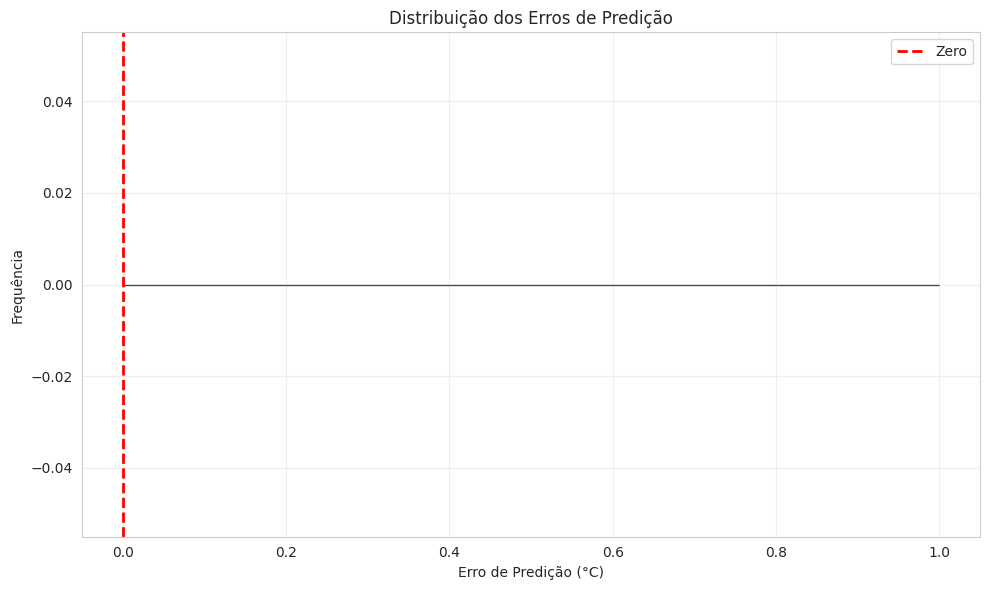

In [ ]:
# Distribuição de erros
try:
    if 'pred_df' in locals() and not pred_df.empty and 'erro' in pred_df.columns:
        plt.figure(figsize=(10, 6))
        plt.hist(pred_df['erro'], bins=50, edgecolor='black', alpha=0.7)
        plt.xlabel('Erro de Predição (°C)')
        plt.ylabel('Frequência')
        plt.title('Distribuição dos Erros de Predição')
        plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('/home/jovyan/work/distribuicao_erros.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("⚠️ Não há dados de predições disponíveis para gerar o histograma")
except Exception as e:
    print(f"❌ Erro ao gerar histograma: {e}")
